<a href="https://colab.research.google.com/github/dniggl/Insights/blob/main/Predict_Sentiment_about_the_Airlines_using_multiple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Predict sentiment about the airlines using text from tweets.

In [1]:
# Import the software libraries.
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Import the dataset.
data_source_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
airlines = pd.read_csv(data_source_url)

In [3]:
# Show the first 5 rows of the dataset.
airlines.head() 

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


This data originally came from Crowdflower's Data for Everyone library. The data we're providing from Kaggle is a slightly reformatted version of the original source. The data can be found here https://www.kaggle.com/crowdflower/twitter-airline-sentiment

The columns and definitions are described below.

1. tweet_id - tweeter identifier.

2. airline_sentiment - includes negative, neutral and positive sentiments.

3. airline_sentiment_confidence - measure of confidence about the sentiment.

4. negativereason - reason for negative sentiment.

5. negativereason_confidence - measure of confidence about negative sentiment.

6. airline - includes United, US Airways, American, Southwest, Delta and Virgin America.

7. airline_sentiment_gold -

8. name - name of user.

9. negativereason_gold -

10. retweet_count - number of retweets.

11. text - what the user stated in text. 

12. tweet_coord - 

13. tweet_created - date and time tweet was created. (yyyy-mm-dd)

14. tweet_location	- location where tweet was made.

15. user_timezone - timezone where user is located.

In [4]:
# Show information about the data columns.
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

There are 14,640 tweets and 15 columns. There are numeric and categorical variables. Many of the variables contain null or missing values.  

In [5]:
# Show each airline sentiment category and the counts within each category.
airlines["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Text(0, 0.5, 'Airline Sentiment')

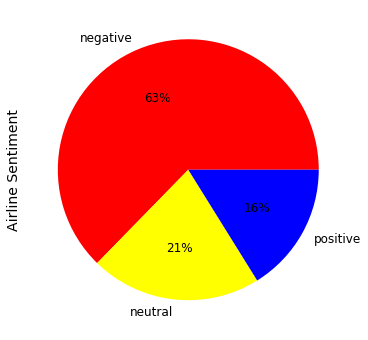

In [6]:
# Visualize the distribution of sentiment across all tweets.
airlines.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%',  fontsize=12, figsize=(9,6), colors=["red", "yellow", "blue"])
plt.ylabel("Airline Sentiment", size=14)

The majority of the tweets are negative (63%), followed by neutral tweets (21%), and then positive tweets (16%).

In [7]:
# Show each airline category and the counts within each category.
airlines["airline"].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

Text(0, 0.5, '          Airline Tweets')

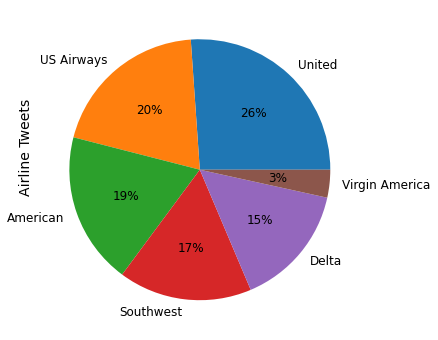

In [8]:
# Visualize the distribution of tweets for each airline.
airlines.airline.value_counts().plot(kind='pie', autopct='%1.0f%%', fontsize=12, figsize=(9,6),)
plt.ylabel("          Airline Tweets", size=14)

United Airline has the highest number of tweets at 26%, followed by US Airways at 20% and then American at 19%.

Text(0.5, 0, 'Airline Sentiments')

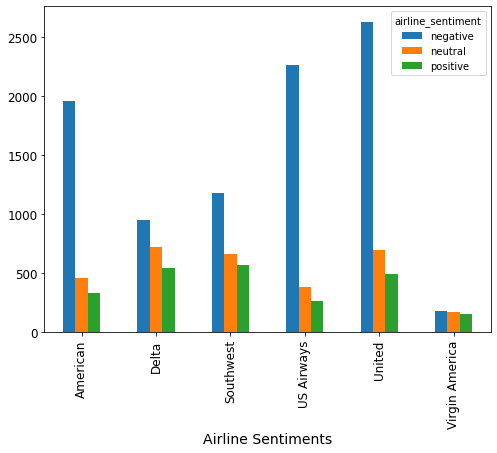

In [9]:
# Visualize the distribution of airline sentiments for each airline.
airline_sentiment = airlines.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar', fontsize=12, figsize=(8,6))
plt.xlabel("Airline Sentiments", size=14)

For most of the airlines, the majority of tweets have a sentiment rating of negative followed by neutral and then positive. United and US Airways have the highest negative ranking. Southwest and Delta have the highest positive ranking. Virgin America is the only airline where the ranking of all three sentiments are almost equal. 

Text(0, 0.5, 'Airline Sentiment Confidence')

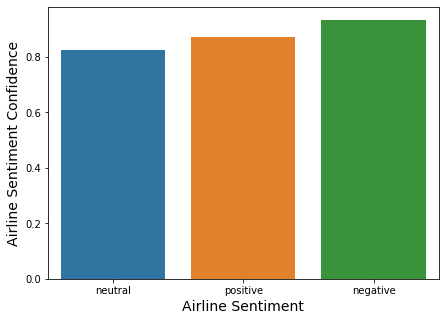

In [11]:
# Visualize the average confidence level for the tweets in each of the sentiment categories. 
fig = plt.figure(figsize = (7,5))
sns.barplot(x = 'airline_sentiment', 
            y = 'airline_sentiment_confidence', 
            data = airlines,
            ci = None)
# set labels
plt.xlabel("Airline Sentiment", size=14)
plt.ylabel("Airline Sentiment Confidence", size=14)

The confidence level for negative tweets is higher compared to positive tweets and neutral tweets.

**Data Cleaning**

We need to divide our dataset into feature and label data sets. The features data set will include only the tweets text which is in the 11th column or index 10. The labels data set will include the sentiment of the tweet that we want to predict which is in column 2 or index 1. We will use the iloc method on the airlines data frame to create the features and labels data sets.

In [12]:
# Divide our dataset into feature and label data sets.
# Feature data set will include only the tweets text which is in the 11th column or index 10.
# Label data set will include the sentiment of the tweet that we want to predict in column 2 or index 1.
features = airlines.iloc[:, 10].values
labels = airlines.iloc[:, 1].values

The text within tweets contain many slang words and punctuation marks. We need to preprocess and clean the text in the tweets before they can be used for training in the machine learning models. Text preprocessing is one of the most important tasks in Natural Language Processing (NLP). For example, you may want to remove all punctuation marks from text documents before they can be used for text classification.  

We will use Regular Expressions (Regex) to perform the text preprocessing tasks.
A Regular Expression is a text string that describes a search pattern which can be used to match or replace patterns inside a string with a minimal amount of code. Python's re package will be used to implement regular expressions. To learn more about regular expressions, go to this site https://stackabuse.com/using-regex-for-text-manipulation-in-python/


In [15]:
# Clean the text data by preprocessing it with regular expressions. 
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters.
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # Remove all single characters as a result of removing the special characters.
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start.
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substitute multiple spaces with a single space.
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Remove prefixed 'b'.
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Convert text to Lowercase.
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)    



**Converting Text to Numbers**

Statistical algorithms use mathematics to train machine learning models and  mathematics only works with numbers. Therefor, to make statistical algorithms work with text, we need to convert the text into numbers. To accomplish this we will use TF-IDF which stands for Term Frequency — Inverse Document Frequency. The idea behind the TF-IDF approach is that the words that occur less in all the tweets and more in an individual tweet contribute more towards classification. The TF-IDF is a score which is applied to every word in every  tweet in our dataset. And for every word, the TF-IDF value increases with every appearance of the word in a tweet, but will gradually decrease with every appearance in other tweets.

TF and IDF are calculated as follows:

*   TF  = (Frequency of a word in the document)/(Total words in the document)
*   IDF = Log((Total number of docs)/(Number of docs containing the word))


If you would like to learn more about TF-IDF, visit this site: https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275


We will use Python's Scikit-Learn library which contains the TfidfVectorizer class that will be used to convert text features into TF-IDF feature vectors.

In [16]:
# Use TfidfVectorizer to convert text features into TF-IDF feature vectors.
# max_features only uses the 2,500 most frequently occurring words.
# min-df includes words that occur in at least 7 documents.
# max_df includes words that occur in a maximum of 80% of the documents.
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.




*   max_features will use the 2500 most frequently occurring words to create a bag of words feature vector. Words that occur less frequently are not that useful for classification.
*   min-df is set to 7 which says to include words that occur in at least 7 tweets.
* max_df is set to 0.8 which specifies to only use those words that occur in a maximum of 80% of the tweets. Words that occur in all tweets are not useful for classification.


In [17]:
# Use train_test_split function to generate training data and test data. Test data set will be 20% of the original data set.
# Training data will be used to train the model. Test data will be used to evaluate the performance of the model. 

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(processed_features, labels, test_size=0.2, random_state=0)




**We will now train models, make predictions and evaluate the performance of four different models.**

**Random Forrest Model**

In [18]:
# Create model object. 
model_rf = RandomForestClassifier(n_estimators = 200, random_state=0)
# Train the model on the training data.
model_rf.fit(x_training_data, y_training_data)
# Make predictions on the test data. 
predictions_rf = model_rf.predict(x_test_data)

In [19]:
# Calculate the Accuracy Score.
rf = accuracy_score(y_test_data, predictions_rf)
print(rf)

0.7599043715846995


In [20]:
# Evaluate the performance of the model.  
print(classification_report(y_test_data, predictions_rf))

              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.60      0.40      0.48       614
    positive       0.76      0.57      0.65       444

    accuracy                           0.76      2928
   macro avg       0.72      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928



The random forrest model accurately predicted 76% of the sentiments based on the text in tweets. 

*   79% correctly predicted negative sentiments. 
*   60% correctly predicted neutral sentiments.
*   76% correctly predicted positive sentiments.

**Logistic Regression Model**

In [23]:
# Create model object. 
model_lr = LogisticRegression(max_iter=150)
# Train the model on the training data.
model_lr.fit(x_training_data, y_training_data)
# Make predictions on the test data. 
predictions_lr = model_lr.predict(x_test_data)

In [24]:
# Calculate the Accuracy Score.
lr = accuracy_score(y_test_data, predictions_lr)
print(lr)

0.7882513661202186


In [25]:
# Show the classification report. 
print(classification_report(y_test_data, predictions_lr))

              precision    recall  f1-score   support

    negative       0.82      0.93      0.87      1870
     neutral       0.64      0.50      0.56       614
    positive       0.81      0.61      0.70       444

    accuracy                           0.79      2928
   macro avg       0.76      0.68      0.71      2928
weighted avg       0.78      0.79      0.78      2928



The logistic regression model accurately predicted 79% of the sentiments based on the text in tweets.

*  82% correctly predicted negative sentiments.
*  64% correctly predicted neutral sentiments.
*  81% correctly predicted positive sentiments.


**K Nearest Neighbors Model**

In [26]:
# Create model object. 
model_kn = KNeighborsClassifier(n_neighbors=9, leaf_size=20)
# Train the model on the training data.
model_kn.fit(x_training_data, y_training_data)
# Make predictions on the test data. 
predictions_kn = model_kn.predict(x_test_data)

In [27]:
# Calculate the Accuracy Score.
kn = accuracy_score(y_test_data, predictions_kn)
print(kn)

0.7247267759562842


In [28]:
# Show the classification report. 
print(classification_report(y_test_data, predictions_kn))

              precision    recall  f1-score   support

    negative       0.81      0.85      0.83      1870
     neutral       0.49      0.47      0.48       614
    positive       0.67      0.56      0.61       444

    accuracy                           0.72      2928
   macro avg       0.65      0.63      0.64      2928
weighted avg       0.72      0.72      0.72      2928



The K Nearest Neighbors model accurately predicted 72% of the sentiments based on the text in tweets.

*  81% correctly predicted negative sentiments.
*  49% correctly predicted neutral sentiments.
*  67% correctly predicted positive sentiments.

**Support Vector Machine Model**

In [29]:
# Create model object. 
model_sv = SVC()
# Train the model on the training data.
model_sv.fit(x_training_data, y_training_data)
# Make predictions on the test data. 
predictions_sv = model_sv.predict(x_test_data)

In [30]:
# Calculate the Accuracy Score.
sv = accuracy_score(y_test_data, predictions_sv)
print(sv)

0.7848360655737705


In [31]:
# Show the classification report. 
print(classification_report(y_test_data, predictions_sv))

              precision    recall  f1-score   support

    negative       0.80      0.95      0.87      1870
     neutral       0.67      0.43      0.52       614
    positive       0.82      0.60      0.69       444

    accuracy                           0.78      2928
   macro avg       0.76      0.66      0.69      2928
weighted avg       0.78      0.78      0.77      2928



The Support Vector Machine model accurately predicted 78% of the sentiments based on the text in tweets.

*  80% correctly predicted negative sentiments.
*  67% correctly predicted neutral sentiments.
*  82% correctly predicted positive sentiments.

,Model,Accuracy_score
1,Logistic Regression,0.788251
3,Support Vector Machine,0.784836
0,Random Forest,0.759904
2,KNeighbours,0.724727


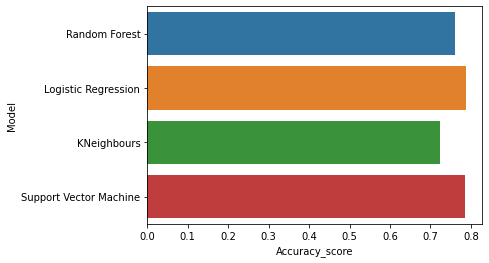

In [32]:
# Show Accuraccy Score by Model.
models = pd.DataFrame({
    'Model':['Random Forest', 'Logistic Regression', 'KNeighbours', 'Support Vector Machine'],
    'Accuracy_score' :[rf, lr, kn, sv]
})
models
sns.barplot(x='Accuracy_score', y='Model', data=models)

models.sort_values(by='Accuracy_score', ascending=False)


Conclusions: 
The sentiment analysis is one of the most commonly performed tasks in Natural Language Processing. This analysis helps measure and determine the overall public opinion about a specific subject matter.  

The random forrest model had the highest accuracy score. This model correctly predicted 79% of the sentiments based on the text in tweets. This was closely  followed by the  support vector machine model that correctly predicted 78% of the sentiments based on the text in tweets. Both random forrest and support vector machine models were better at predicting negative and positive sentiments than neutral sentiments.    

The models accuracy may be improved by having a larger dataset with more balance between different types of sentiments. Also tuning some of the models hyper parameters may increase the accuracy scores.  